# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the network flow dataset.

## Load and normalize data

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/scratch/sj2363/hsn/attack_generate/gan_attack_generate/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from importlib import reload
import os
import utils, models
reload(utils)
reload(models)
from utils import model_inputs, get_flow_dataset
from models import generator, discriminator
from sklearn.preprocessing import normalize

In [3]:
(benign_train, benign_test), (attack_train, attack_test) = get_flow_dataset(os.path.join('data', 'ids2017_sampled.csv'))

/scratch/sj2363/hsn/attack_generate/gan_attack_generate/.env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
benign_train.shape

(1500, 47)

In [5]:
benign_test.shape

(3500, 47)

In [6]:
attack_train.shape

(1650, 47)

In [7]:
attack_test.shape

(3850, 47)

In [8]:
def max_norm(dataset):
    dataset = dataset - dataset.min(axis=0)
    dataset = normalize(dataset, axis=0, norm='max')
    return dataset

In [9]:
# normalize data
benign_train = max_norm(benign_train)
benign_test = max_norm(benign_test)
attack_train = max_norm(attack_train)
attack_test = max_norm(attack_test)

## Hyperparameters

In [10]:
# Size of input flow to discriminator
input_size = benign_train.shape[1]
# Size of latent vector to generator
z_size = 2
# Sizes of hidden layers in generator and discriminator
g_hidden_size = [128, 64]
d_hidden_size = [128, 64]
# Leak factor for leaky ReLU
alpha = 0.01

## Build network

Now we're building the network from the functions defined above.

First is to get our inputs, `input_benign, input_z, input_attack_remains` from `model_inputs` using the sizes of the input and z.

Then, we'll create the generator, `generator(input_z, z_size)`. This builds the generator with the appropriate input and output sizes.

Then the discriminators. We'll build two of them, one for benign flow data and one for attack flow data. Since we want the weights to be the same for both benign and attack flow data, we need to reuse the variables. For the attack flow data, we're getting it from the output of the generator concatenated with remaining part of attack feature called `g_model`. So the benign data discriminator is `discriminator(input_benign)` while the attack discriminator is `discriminator(g_model, reuse=True)`.

In [11]:
tf.reset_default_graph()

# Create our input placeholders
input_benign, input_z, input_attack_remains = model_inputs(input_size, z_size, attack_remains_dim=input_size - z_size)

# Build the model
z_generated, g_hidden = generator(input_z, z_size, n_units=[z_size] + g_hidden_size, alpha=alpha)
g_model = tf.concat([z_generated, input_attack_remains], 1)
# g_model is the generator output concatenated with the remaining part of attack features

d_model_benign, d_logits_benign, d_hidden_benign = discriminator(input_benign,
                                                                 n_units= [input_size] + d_hidden_size,
                                                                 alpha=alpha)
d_model_attack, d_logits_attack, d_hidden_attack = discriminator(g_model,
                                                                 reuse=True,
                                                                 n_units=[input_size] + d_hidden_size,
                                                                 alpha=alpha)

## Discriminator and Generator Losses

Now we need to calculate the losses, which is a little tricky. For the discriminator, the total loss is the sum of the losses for benign and attack flows, `d_loss = d_loss_benign + d_loss_attack`. The losses will by sigmoid cross-entropys, which we can get with `tf.nn.sigmoid_cross_entropy_with_logits`. We'll also wrap that in `tf.reduce_mean` to get the mean for all the flows in the batch. So the losses will look something like 

```python
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
```

For the benign flow logits, we'll use `d_logits_benign` which we got from the discriminator in the cell above. For the labels, we want them to be all zeros, since these are all benign flows. In TensorFlow, it looks something like `labels = tf.zeros_like(tensor)`

The discriminator loss for the attack flow data is similar. The logits are `d_logits_attack`, which we got from passing the generator output concatenated with remaing part of attack flow features to the discriminator. These attack logits are used with labels of all ones. Remember that we want the discriminator to output 0 for benign flows and 1 for attack flows, so we need to set up the losses to reflect that.

Finally, the generator losses are using `d_logits_attack`, the attack flow logits. But, now the labels are all zeros. The generator is trying to fool the discriminator, so it wants to discriminator to output zeros for attack flows.

In [12]:
# Calculate losses
d_loss_benign = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_benign, 
                                                          labels=tf.zeros_like(d_logits_benign)))
d_loss_attack = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_attack, 
                                                          labels=tf.ones_like(d_logits_attack)))
d_loss = d_loss_benign + d_loss_attack

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_attack,
                                                     labels=tf.zeros_like(d_logits_attack)))

## Optimizers

We want to update the generator and discriminator variables separately. So we need to get the variables for each part build optimizers for the two parts. To get all the trainable variables, we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph.

For the generator optimizer, we only want to generator variables. Our past selves were nice and used a variable scope to start all of our generator variable names with `generator`. So, we just need to iterate through the list from `tf.trainable_variables()` and keep variables to start with `generator`. Each variable object has an attribute `name` which holds the name of the variable as a string (`var.name == 'weights_0'` for instance). 

We can do something similar with the discriminator. All the variables in the discriminator start with `discriminator`.

Then, in the optimizer we pass the variable lists to `var_list` in the `minimize` method. This tells the optimizer to only update the listed variables. Something like `tf.train.AdamOptimizer().minimize(loss, var_list=var_list)` will only train the variables in `var_list`.

In [13]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [14]:
from copy import deepcopy
import time

batch_size = 100
epochs = 1000
losses = []
original_flows, generated_flows, attack_scores = [], [], []
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
# TODO: add outer-loop, which is test number, to see convergence trends
# TODO: modify training process - choose random 2 features and give 2 outputs randomly back
with tf.Session() as sess:
    total_start = time.time()
    sess.run(tf.global_variables_initializer())
    init_benign_test_score = sess.run(d_model_benign, feed_dict={input_benign: benign_test})
    init_attack_test_score = sess.run(d_model_benign, feed_dict={input_benign: attack_test})
    for e in range(epochs):
        start = time.time()
        np.random.shuffle(benign_train)
        np.random.shuffle(attack_train)
        original_flows.append([])
        generated_flows.append([])
        attack_scores.append([])
        for ii in range(benign_train.shape[0]//batch_size):
            batch_benign = benign_train[ii * batch_size:(ii + 1) * batch_size]
            
            batch_attack = attack_train[ii * batch_size:(ii + 1) * batch_size]
            batch_z = batch_attack[:,:z_size]
            batch_attack_remains = batch_attack[:,z_size:]
            
            if ii % 5 == 0:
                original_flow = batch_attack
                generated_flow = sess.run(g_model, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
                attack_score = sess.run(d_model_attack, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
                original_flows[-1].append(deepcopy(original_flow[0]))
                generated_flows[-1].append(generated_flow[0])
                attack_scores[-1].append(attack_score[0][0])
                
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_benign: batch_benign, input_z: batch_z, input_attack_remains: batch_attack_remains})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_benign: batch_benign, input_attack_remains: batch_attack_remains})
        train_loss_g = g_loss.eval({input_z: batch_z, input_attack_remains: batch_attack_remains})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g),
              "Time elapsed: {:.4f}".format(time.time() - start)
             )    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        saver.save(sess, './checkpoints/generator.ckpt')
    print('Total training time:', time.time() - total_start)
    
    final_benign_test_score = sess.run(d_model_benign, feed_dict={input_benign: benign_test})
    final_attack_test_score = sess.run(d_model_benign, feed_dict={input_benign: attack_test})

Epoch 1/1000... Discriminator Loss: 0.5954... Generator Loss: 1.9909 Time elapsed: 0.4627
Epoch 2/1000... Discriminator Loss: 0.1953... Generator Loss: 3.8087 Time elapsed: 0.0800
Epoch 3/1000... Discriminator Loss: 0.1044... Generator Loss: 5.4256 Time elapsed: 0.0788
Epoch 4/1000... Discriminator Loss: 0.0515... Generator Loss: 6.4747 Time elapsed: 0.0767
Epoch 5/1000... Discriminator Loss: 0.0623... Generator Loss: 6.4462 Time elapsed: 0.0788
Epoch 6/1000... Discriminator Loss: 0.0549... Generator Loss: 7.2718 Time elapsed: 0.0805
Epoch 7/1000... Discriminator Loss: 0.1000... Generator Loss: 7.5638 Time elapsed: 0.0784
Epoch 8/1000... Discriminator Loss: 0.0377... Generator Loss: 7.9590 Time elapsed: 0.0826
Epoch 9/1000... Discriminator Loss: 0.0849... Generator Loss: 7.6155 Time elapsed: 0.0758
Epoch 10/1000... Discriminator Loss: 0.0277... Generator Loss: 8.0469 Time elapsed: 0.0850
Epoch 11/1000... Discriminator Loss: 0.0052... Generator Loss: 9.6210 Time elapsed: 0.0795
Epoch 12

Epoch 91/1000... Discriminator Loss: 0.0012... Generator Loss: 10.6509 Time elapsed: 0.0872
Epoch 92/1000... Discriminator Loss: 0.0054... Generator Loss: 10.5898 Time elapsed: 0.0825
Epoch 93/1000... Discriminator Loss: 0.0023... Generator Loss: 11.1411 Time elapsed: 0.0799
Epoch 94/1000... Discriminator Loss: 0.0022... Generator Loss: 11.0837 Time elapsed: 0.0808
Epoch 95/1000... Discriminator Loss: 0.0172... Generator Loss: 11.3259 Time elapsed: 0.0823
Epoch 96/1000... Discriminator Loss: 0.0020... Generator Loss: 11.7006 Time elapsed: 0.0831
Epoch 97/1000... Discriminator Loss: 0.0021... Generator Loss: 10.3424 Time elapsed: 0.0757
Epoch 98/1000... Discriminator Loss: 0.0009... Generator Loss: 11.5819 Time elapsed: 0.0763
Epoch 99/1000... Discriminator Loss: 0.0759... Generator Loss: 10.6090 Time elapsed: 0.0842
Epoch 100/1000... Discriminator Loss: 0.1222... Generator Loss: 14.2875 Time elapsed: 0.0762
Epoch 101/1000... Discriminator Loss: 0.0879... Generator Loss: 16.2583 Time el

Epoch 180/1000... Discriminator Loss: 0.0003... Generator Loss: 18.2575 Time elapsed: 0.0829
Epoch 181/1000... Discriminator Loss: 0.0007... Generator Loss: 17.4651 Time elapsed: 0.0705
Epoch 182/1000... Discriminator Loss: 0.0002... Generator Loss: 17.2835 Time elapsed: 0.0797
Epoch 183/1000... Discriminator Loss: 0.0012... Generator Loss: 18.8502 Time elapsed: 0.0773
Epoch 184/1000... Discriminator Loss: 0.0003... Generator Loss: 18.0112 Time elapsed: 0.0741
Epoch 185/1000... Discriminator Loss: 0.0001... Generator Loss: 18.6187 Time elapsed: 0.0794
Epoch 186/1000... Discriminator Loss: 0.0001... Generator Loss: 18.9751 Time elapsed: 0.0786
Epoch 187/1000... Discriminator Loss: 0.0001... Generator Loss: 18.7263 Time elapsed: 0.0773
Epoch 188/1000... Discriminator Loss: 0.0001... Generator Loss: 17.9676 Time elapsed: 0.0794
Epoch 189/1000... Discriminator Loss: 0.0002... Generator Loss: 18.6353 Time elapsed: 0.0790
Epoch 190/1000... Discriminator Loss: 0.0001... Generator Loss: 17.894

Epoch 270/1000... Discriminator Loss: 0.0005... Generator Loss: 18.6704 Time elapsed: 0.0813
Epoch 271/1000... Discriminator Loss: 0.0540... Generator Loss: 18.8984 Time elapsed: 0.0806
Epoch 272/1000... Discriminator Loss: 0.0030... Generator Loss: 17.5558 Time elapsed: 0.0759
Epoch 273/1000... Discriminator Loss: 0.0015... Generator Loss: 18.5513 Time elapsed: 0.0750
Epoch 274/1000... Discriminator Loss: 0.0001... Generator Loss: 20.0764 Time elapsed: 0.0843
Epoch 275/1000... Discriminator Loss: 0.0017... Generator Loss: 17.9164 Time elapsed: 0.0853
Epoch 276/1000... Discriminator Loss: 0.0017... Generator Loss: 19.6946 Time elapsed: 0.0879
Epoch 277/1000... Discriminator Loss: 0.0016... Generator Loss: 18.9942 Time elapsed: 0.0640
Epoch 278/1000... Discriminator Loss: 0.0320... Generator Loss: 20.1536 Time elapsed: 0.0757
Epoch 279/1000... Discriminator Loss: 0.0000... Generator Loss: 20.3814 Time elapsed: 0.0839
Epoch 280/1000... Discriminator Loss: 0.0029... Generator Loss: 20.838

Epoch 359/1000... Discriminator Loss: 0.0006... Generator Loss: 25.5001 Time elapsed: 0.0858
Epoch 360/1000... Discriminator Loss: 0.0084... Generator Loss: 25.5896 Time elapsed: 0.0804
Epoch 361/1000... Discriminator Loss: 0.0008... Generator Loss: 24.0388 Time elapsed: 0.0723
Epoch 362/1000... Discriminator Loss: 0.0008... Generator Loss: 25.3860 Time elapsed: 0.0818
Epoch 363/1000... Discriminator Loss: 0.0007... Generator Loss: 26.1149 Time elapsed: 0.0756
Epoch 364/1000... Discriminator Loss: 0.0001... Generator Loss: 25.8814 Time elapsed: 0.0803
Epoch 365/1000... Discriminator Loss: 0.0165... Generator Loss: 26.2288 Time elapsed: 0.0878
Epoch 366/1000... Discriminator Loss: 0.0004... Generator Loss: 27.2856 Time elapsed: 0.0805
Epoch 367/1000... Discriminator Loss: 0.0027... Generator Loss: 25.6299 Time elapsed: 0.0805
Epoch 368/1000... Discriminator Loss: 0.0011... Generator Loss: 26.7647 Time elapsed: 0.0774
Epoch 369/1000... Discriminator Loss: 0.0002... Generator Loss: 26.375

Epoch 449/1000... Discriminator Loss: 0.0001... Generator Loss: 37.3781 Time elapsed: 0.0763
Epoch 450/1000... Discriminator Loss: 0.0005... Generator Loss: 37.3701 Time elapsed: 0.0877
Epoch 451/1000... Discriminator Loss: 0.0002... Generator Loss: 37.8819 Time elapsed: 0.0875
Epoch 452/1000... Discriminator Loss: 0.0015... Generator Loss: 35.5302 Time elapsed: 0.0792
Epoch 453/1000... Discriminator Loss: 0.0003... Generator Loss: 36.2010 Time elapsed: 0.0838
Epoch 454/1000... Discriminator Loss: 0.0000... Generator Loss: 38.6444 Time elapsed: 0.0784
Epoch 455/1000... Discriminator Loss: 0.0003... Generator Loss: 35.2706 Time elapsed: 0.0883
Epoch 456/1000... Discriminator Loss: 0.0038... Generator Loss: 38.1379 Time elapsed: 0.0797
Epoch 457/1000... Discriminator Loss: 0.0001... Generator Loss: 36.2122 Time elapsed: 0.0810
Epoch 458/1000... Discriminator Loss: 0.0006... Generator Loss: 39.4659 Time elapsed: 0.0774
Epoch 459/1000... Discriminator Loss: 0.0002... Generator Loss: 35.787

Epoch 538/1000... Discriminator Loss: 0.0000... Generator Loss: 40.5566 Time elapsed: 0.0846
Epoch 539/1000... Discriminator Loss: 0.0000... Generator Loss: 32.9301 Time elapsed: 0.0813
Epoch 540/1000... Discriminator Loss: 0.0000... Generator Loss: 42.7137 Time elapsed: 0.0824
Epoch 541/1000... Discriminator Loss: 0.0001... Generator Loss: 39.2322 Time elapsed: 0.0757
Epoch 542/1000... Discriminator Loss: 0.0000... Generator Loss: 35.7178 Time elapsed: 0.0762
Epoch 543/1000... Discriminator Loss: 0.0000... Generator Loss: 38.3288 Time elapsed: 0.0738
Epoch 544/1000... Discriminator Loss: 0.0001... Generator Loss: 37.3945 Time elapsed: 0.0834
Epoch 545/1000... Discriminator Loss: 0.0002... Generator Loss: 33.3420 Time elapsed: 0.0899
Epoch 546/1000... Discriminator Loss: 0.0002... Generator Loss: 37.2776 Time elapsed: 0.0821
Epoch 547/1000... Discriminator Loss: 0.0005... Generator Loss: 36.2954 Time elapsed: 0.0763
Epoch 548/1000... Discriminator Loss: 0.0000... Generator Loss: 40.926

Epoch 628/1000... Discriminator Loss: 0.0046... Generator Loss: 44.0994 Time elapsed: 0.0765
Epoch 629/1000... Discriminator Loss: 0.0005... Generator Loss: 42.8322 Time elapsed: 0.0802
Epoch 630/1000... Discriminator Loss: 0.0001... Generator Loss: 44.8024 Time elapsed: 0.0769
Epoch 631/1000... Discriminator Loss: 0.0004... Generator Loss: 46.1704 Time elapsed: 0.0709
Epoch 632/1000... Discriminator Loss: 0.0004... Generator Loss: 43.2742 Time elapsed: 0.0771
Epoch 633/1000... Discriminator Loss: 0.0005... Generator Loss: 44.9386 Time elapsed: 0.0699
Epoch 634/1000... Discriminator Loss: 0.0013... Generator Loss: 44.0010 Time elapsed: 0.0696
Epoch 635/1000... Discriminator Loss: 0.0006... Generator Loss: 43.8132 Time elapsed: 0.0766
Epoch 636/1000... Discriminator Loss: 0.0002... Generator Loss: 43.6437 Time elapsed: 0.0791
Epoch 637/1000... Discriminator Loss: 0.0001... Generator Loss: 41.3986 Time elapsed: 0.0763
Epoch 638/1000... Discriminator Loss: 0.0002... Generator Loss: 43.223

Epoch 718/1000... Discriminator Loss: 0.0000... Generator Loss: 47.6529 Time elapsed: 0.0816
Epoch 719/1000... Discriminator Loss: 0.0000... Generator Loss: 46.9288 Time elapsed: 0.0883
Epoch 720/1000... Discriminator Loss: 0.0000... Generator Loss: 46.6962 Time elapsed: 0.0839
Epoch 721/1000... Discriminator Loss: 0.0000... Generator Loss: 48.4283 Time elapsed: 0.0844
Epoch 722/1000... Discriminator Loss: 0.0010... Generator Loss: 42.1233 Time elapsed: 0.0886
Epoch 723/1000... Discriminator Loss: 0.0002... Generator Loss: 44.4749 Time elapsed: 0.0762
Epoch 724/1000... Discriminator Loss: 0.0002... Generator Loss: 45.5832 Time elapsed: 0.0768
Epoch 725/1000... Discriminator Loss: 0.0000... Generator Loss: 45.2435 Time elapsed: 0.0821
Epoch 726/1000... Discriminator Loss: 0.0000... Generator Loss: 48.1219 Time elapsed: 0.0748
Epoch 727/1000... Discriminator Loss: 0.0001... Generator Loss: 47.5668 Time elapsed: 0.0803
Epoch 728/1000... Discriminator Loss: 0.0007... Generator Loss: 50.258

Epoch 807/1000... Discriminator Loss: 0.0000... Generator Loss: 50.8746 Time elapsed: 0.0840
Epoch 808/1000... Discriminator Loss: 0.0005... Generator Loss: 51.2293 Time elapsed: 0.0904
Epoch 809/1000... Discriminator Loss: 0.0000... Generator Loss: 50.0801 Time elapsed: 0.0800
Epoch 810/1000... Discriminator Loss: 0.0000... Generator Loss: 48.8908 Time elapsed: 0.0850
Epoch 811/1000... Discriminator Loss: 0.0000... Generator Loss: 52.7937 Time elapsed: 0.0760
Epoch 812/1000... Discriminator Loss: 0.0000... Generator Loss: 50.2972 Time elapsed: 0.0801
Epoch 813/1000... Discriminator Loss: 0.0001... Generator Loss: 51.2844 Time elapsed: 0.0763
Epoch 814/1000... Discriminator Loss: 0.0000... Generator Loss: 49.8219 Time elapsed: 0.0759
Epoch 815/1000... Discriminator Loss: 0.0000... Generator Loss: 51.2358 Time elapsed: 0.0812
Epoch 816/1000... Discriminator Loss: 0.0000... Generator Loss: 49.2801 Time elapsed: 0.0780
Epoch 817/1000... Discriminator Loss: 0.0003... Generator Loss: 51.511

Epoch 896/1000... Discriminator Loss: 0.0000... Generator Loss: 54.3548 Time elapsed: 0.0816
Epoch 897/1000... Discriminator Loss: 0.0000... Generator Loss: 52.0797 Time elapsed: 0.0804
Epoch 898/1000... Discriminator Loss: 0.0000... Generator Loss: 55.3807 Time elapsed: 0.0852
Epoch 899/1000... Discriminator Loss: 0.0000... Generator Loss: 52.0822 Time elapsed: 0.0734
Epoch 900/1000... Discriminator Loss: 0.0000... Generator Loss: 55.6827 Time elapsed: 0.0718
Epoch 901/1000... Discriminator Loss: 0.0000... Generator Loss: 55.9464 Time elapsed: 0.0820
Epoch 902/1000... Discriminator Loss: 0.0000... Generator Loss: 53.0441 Time elapsed: 0.0773
Epoch 903/1000... Discriminator Loss: 0.0000... Generator Loss: 52.3324 Time elapsed: 0.0815
Epoch 904/1000... Discriminator Loss: 0.0000... Generator Loss: 54.8126 Time elapsed: 0.0788
Epoch 905/1000... Discriminator Loss: 0.0000... Generator Loss: 52.2110 Time elapsed: 0.0702
Epoch 906/1000... Discriminator Loss: 0.0000... Generator Loss: 53.022

Epoch 986/1000... Discriminator Loss: 0.0000... Generator Loss: 55.7382 Time elapsed: 0.0864
Epoch 987/1000... Discriminator Loss: 0.0000... Generator Loss: 53.0205 Time elapsed: 0.0741
Epoch 988/1000... Discriminator Loss: 0.0000... Generator Loss: 56.7998 Time elapsed: 0.0749
Epoch 989/1000... Discriminator Loss: 0.0000... Generator Loss: 55.1330 Time elapsed: 0.0740
Epoch 990/1000... Discriminator Loss: 0.0000... Generator Loss: 57.8187 Time elapsed: 0.0724
Epoch 991/1000... Discriminator Loss: 0.0000... Generator Loss: 55.1612 Time elapsed: 0.0785
Epoch 992/1000... Discriminator Loss: 0.0000... Generator Loss: 52.6713 Time elapsed: 0.0882
Epoch 993/1000... Discriminator Loss: 0.0000... Generator Loss: 53.3228 Time elapsed: 0.0848
Epoch 994/1000... Discriminator Loss: 0.0000... Generator Loss: 55.9895 Time elapsed: 0.0786
Epoch 995/1000... Discriminator Loss: 0.0000... Generator Loss: 51.8544 Time elapsed: 0.0764
Epoch 996/1000... Discriminator Loss: 0.0000... Generator Loss: 53.623

## Training loss

Here we'll check out the training losses for the generator and discriminator.

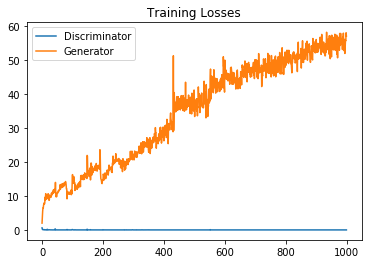

In [15]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Test Part

In [16]:
# TODO: test if discriminator is fooled

In [17]:
print('Accuracy before training')
print('Discriminator benign test accuracy:', (init_benign_test_score <= 0.5).sum() / benign_test.shape[0])
print('Discriminator attack test accuracy:', (init_attack_test_score > 0.5).sum() / attack_test.shape[0])
print('Discriminator total test accuracy:',
      ((init_benign_test_score <= 0.5).sum() + (init_attack_test_score > 0.5).sum()) / (benign_test.shape[0] + attack_test.shape[0]))

Accuracy before training
Discriminator benign test accuracy: 0.9968571428571429
Discriminator attack test accuracy: 0.0
Discriminator total test accuracy: 0.4746938775510204


In [18]:
print('Accuracy after training')
print('Discriminator benign test accuracy:', (final_benign_test_score <= 0.5).sum() / benign_test.shape[0])
print('Discriminator attack test accuracy:', (final_attack_test_score > 0.5).sum() / attack_test.shape[0])
print('Discriminator total test accuracy:',
      ((final_benign_test_score <= 0.5).sum() + (final_attack_test_score > 0.5).sum()) / (benign_test.shape[0] + attack_test.shape[0]))

Accuracy after training
Discriminator benign test accuracy: 1.0
Discriminator attack test accuracy: 1.0
Discriminator total test accuracy: 1.0


# Output Visualization

In [19]:
import math

def split_to_two_nearest_factor(x):
    sqrt_x = int(math.sqrt(x))
    i = sqrt_x
    while x % i != 0:
        i -= 1
    return (i, x // i)
fig_size = split_to_two_nearest_factor(input_size)
import numpy as np
import matplotlib.pyplot as plt

fooled = 0

# fig=plt.figure(figsize=(fig_size[0] * 5, fig_size[1] * 5))
# columns = 2
rows = len(original_flows)
for i in range(rows):
#     original_img = original_flows[i][0]
#     generated_img = generated_flows[i][0]
#     ax_original = fig.add_subplot(rows, columns, i * 2 + 1)
#     ax_original.set_title('Epoch {epoch}'.format(epoch=i + 1))
#     plt.imshow(original_img.reshape(fig_size[0],fig_size[1]), cmap='gray')
#     ax_generated = fig.add_subplot(rows, columns, i * 2 + 2)
#     plt.imshow(generated_img.reshape(fig_size[0],fig_size[1]), cmap='gray')
    if attack_scores[i][0] <= 0.5:
#         ax_generated.set_title('Fooled:' + str(attack_scores[i][0]))
        fooled += 1
#     else:
#         ax_generated.set_title('Just close:' + str(attack_scores[i][0]))
# plt.show()
print('Fooled rate:', fooled / len(original_flows))

Fooled rate: 0.001


# Generate attack flows

In [20]:
#TODO: generate attack flows for Kaihua's discrimination